# LSTM-RNN Modell mit den neu aufbereiteten Daten im Zuge der Thesis
Hierbei wurde ein LSTM-RNN Modell trainiert mit den neu aufbereiteten Daten im Zuge dieser Thesis. Die Aufteilung in Trainings- und Testdaten ist hierbei im Dokument enthalten, da kein Shuffle enthalten ist und die Zeitreihendaten sortiert sind (Split immer an derselben Stelle). Man hätte diesen Prozess auslagern können, bedingt durch Google Colab war es jedoch einfacher den Prozess in den einzelnen Dokumenten zu behalten.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, CuDNNGRU, CuDNNLSTM, Bidirectional
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FILE_NAME = "data_without_weather.csv"
FS_ROOT_PATH = '/content/drive/MyDrive/sensalytics/Rohdaten/'
CSV_PATH = FS_ROOT_PATH + FILE_NAME

## Data-Import:

In [ ]:
dataset = pd.read_csv(filepath_or_buffer=CSV_PATH, index_col='Date_Time')
dataset.head(5)

,Visitor In,Visitor Out,Ø Occupancy,POS served,Ø Total Occupancy (Payer),Month,Weekday,Weekend,Hour
Date_Time,,,,,,,,,
2021-08-12 06:56:00,1,1,0,0,0,8,3,0,6
2021-08-12 06:58:00,0,1,0,2,0,8,3,0,6
2021-08-12 06:59:00,1,1,0,0,0,8,3,0,6
2021-08-12 07:00:00,2,0,1,0,0,8,3,0,7
2021-08-12 07:01:00,3,0,4,0,0,8,3,0,7


In [ ]:
dataset.index = pd.to_datetime(dataset.index)

Hier wird die Label-Spalte vom Dataset getrennt.

In [ ]:
y = dataset.pop('Ø Total Occupancy (Payer)')
display(y.head(5))

Date_Time
2021-08-12 06:56:00    0
2021-08-12 06:58:00    0
2021-08-12 06:59:00    0
2021-08-12 07:00:00    0
2021-08-12 07:01:00    0
Name: Ø Total Occupancy (Payer), dtype: int64

## Modell mit Sliding Window (Many-To-One trainieren):


Hier wird der Dataset in Trainings- und Testdaten eingeteilt. Dabei ist wichtig das Flag *shuffle=False* zu setzen, damit die Daten nicht gemischt werden. Danach werden die Daten mit Hilfe des **StandardScaler()** oder des **MinMaxScaler()** scaliert. Das verbessert das Training, da sich der Wertebereich der Features nicht so groß unterscheidet.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(dataset, y, test_size=0.2, random_state=0, shuffle=False)

input_scaler = MinMaxScaler()

input_scaler.fit(train_x, train_y)

train_x = input_scaler.transform(train_x)
test_x = input_scaler.transform(test_x)

Die Eingabe für jede RNN-Schicht muss dreidimensional sein. <br>
Die drei Dimensionen dieser Eingabe sind:

- **Samples:** Eine Sequenz ist eine Probe. Eine Batch besteht aus einer oder mehreren Proben.
- **Time Steps:** Ein Zeitschritt ist ein Beobachtungspunkt in der Stichprobe.
- **Features.** Ein Merkmal ist eine Beobachtung pro Zeitschritt.

---

Im *Many-To-One*-Ansatz werden hier die Daten mit dem Sliding-Window verfahren angepasst. Hierbei werden die letzten **n** Timestamps genommen um die nächsten **m** Timestamps vorherzusagen. Mit der Funktion *to_supervised()* werden die Tranings- und Testdaten deshalb angepasst. 

In [ ]:
N_INPUT = 180
M_OUTPUT = 10
FEATURES = dataset.shape[1]
EPOCHS = 100
BATCH_SIZE = 64

In [ ]:
def to_supervised(data, label, n_input, output_ix):
	X, y = list(), list()
	ind = list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(label)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		ix_output = ix_end + output_ix

		# ensure we have enough data for this instance
		if ix_output < len(label):
			X.append(data[ix_start:ix_end])
			y.append(label[ix_end:ix_output])
			ind.append(label.index[ix_end:ix_output])
		# move along one time step
		ix_start += 1
	
	return np.array(X), np.array(y), np.array(ind)

In [ ]:
train_x, train_y, train_ind = to_supervised(train_x, train_y, N_INPUT, M_OUTPUT)
test_x, test_y, test_ind = to_supervised(test_x, test_y, N_INPUT, M_OUTPUT)
print("train_x Shape:", train_x.shape)
print("train_y Shape:", train_y.shape)
print("test_x Shape:", test_x.shape)
print("test_y Shape:", test_y.shape)

train_x Shape: (67502, 180, 8)
train_y Shape: (67502, 10)
test_x Shape: (16733, 180, 8)
test_y Shape: (16733, 10)


Implementierung eines Modells ohne die Optimierung der Parameter zum Testen:

In [ ]:
# LSTM-RNN Many-To-One Model
model_1 = Sequential()
model_1.add(LSTM(24, return_sequences=True, input_shape=(N_INPUT, FEATURES)))
model_1.add(LSTM(8))
model_1.add(Dense(32))
model_1.add(Dense(M_OUTPUT))

model_1.compile(loss='mse', optimizer=keras.optimizers.Adam(0.01), metrics=['mae', 'mse'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 180, 24)           3264      
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 8)                 1088      
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 4,970
Trainable params: 4,970
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model_1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, verbose=1, callbacks=[early_stop])

Epoch 1/100
528/528 [==============================] - 15s 20ms/step - loss: 21.7918 - mae: 3.4969 - mse: 21.7918 - val_loss: 12.9954 - val_mae: 2.8060 - val_mse: 12.9954
Epoch 2/100
528/528 [==============================] - 10s 19ms/step - loss: 12.1593 - mae: 2.6597 - mse: 12.1593 - val_loss: 11.0056 - val_mae: 2.5499 - val_mse: 11.0056
Epoch 3/100
528/528 [==============================] - 10s 19ms/step - loss: 11.0325 - mae: 2.5334 - mse: 11.0325 - val_loss: 10.3608 - val_mae: 2.4378 - val_mse: 10.3608
Epoch 4/100
528/528 [==============================] - 10s 19ms/step - loss: 10.7569 - mae: 2.5024 - mse: 10.7569 - val_loss: 10.2151 - val_mae: 2.4035 - val_mse: 10.2151
Epoch 5/100
528/528 [==============================] - 10s 19ms/step - loss: 10.4446 - mae: 2.4680 - mse: 10.4446 - val_loss: 10.3967 - val_mae: 2.5009 - val_mse: 10.3967
Epoch 6/100
528/528 [==============================] - 10s 19ms/step - loss: 10.2225 - mae: 2.4435 - mse: 10.2225 - val_loss: 9.9502 - val_mae: 2

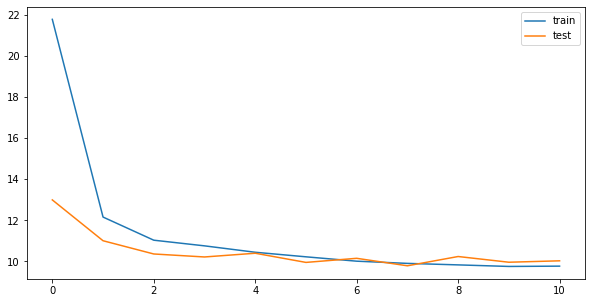

In [ ]:
# plot history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
loss, mae, mse = model_1.evaluate(test_x, test_y, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

523/523 - 4s - loss: 10.0276 - mae: 2.3889 - mse: 10.0276 - 4s/epoch - 8ms/step
Testing set Mean Abs Error:  2.39 MPG


In [ ]:
y_hat = model_1.predict(test_x)
y_hat = y_hat.clip(min=0)

In [ ]:
def calculate_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  rmsle = mean_squared_log_error(y_true, y_pred, squared=False)
  mae = mean_absolute_error(y_true, y_pred)
  med = median_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  
  return {'MSE': mse, 'RMSE': rmse, 'RMSLE': rmsle, 'MAE':mae, 'MED':med, 'R2':r2}

def evaluate_model(y_true, y_pred):
  df_scores = pd.DataFrame(columns=['MSE', 'RMSE', 'RMSLE', 'MAE', 'MED', 'R2'])

  # Berechnung der Metrics über die einzelnen Vorhersagen
  for i in range(y_true.shape[1]):
    score = pd.Series(calculate_metrics(y_true[:, i], y_pred[:, i]), name='min' + str(i+1) + ':')
    df_scores = df_scores.append(score)
  
  # Berechnugn der Metrics über alle Vorhersagen
  scores_total = pd.Series(calculate_metrics(y_true, y_pred), name='total:')
  df_scores= df_scores.append(scores_total)

  return df_scores

In [ ]:
df_scores = evaluate_model(test_y, y_hat)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,9.340806,3.056273,0.399888,2.319205,1.792185,0.747782
min2:,9.543581,3.089269,0.401843,2.342377,1.806295,0.742337
min3:,9.825467,3.134560,0.401625,2.368045,1.827621,0.734759
min4:,9.979206,3.158988,0.401502,2.382126,1.829325,0.730634
min5:,10.080345,3.174956,0.401257,2.390854,1.834782,0.727929
min6:,10.181219,3.190802,0.400507,2.399682,1.842201,0.725231
min7:,10.232623,3.198847,0.401049,2.404596,1.853760,0.723874
min8:,10.309708,3.210873,0.400439,2.407890,1.855936,0.721828
min9:,10.344135,3.216230,0.400445,2.407415,1.843270,0.720934
min10:,10.398693,3.224700,0.401243,2.413791,1.857601,0.719496


In [ ]:
np.std(test_y)

6.087091183799563

### Tuning der Hyperparameter mit Hilfe eines Keras Tuners:

In [ ]:
def build_model(hp):
  # Sequential Model:
  model = Sequential()

  # Input LSTM Layer with Input-Shape:
  model.add(LSTM(
    units=hp.Int('layer_1_units',  min_value=8, max_value=128, step=8), 
    input_shape=(N_INPUT, FEATURES),
    return_sequences=True
  ))

  # Second LSTM-Layer
  model.add(LSTM(
    units=hp.Int('layer_2_units', min_value=8, max_value=128, step=8)
  ))

  # Dropout-Layer:
  if hp.Boolean('dropout'):
    model.add(
      Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.0, step=0.1)
    ))

  # Dense Layer with units:
  model.add(Dense(
    units=hp.Int('units_dense', min_value=32, max_value=512, step=32)
  ))

  # Dense Layer with Output-Shape:
  model.add(Dense(
    units=M_OUTPUT
  ))

  # Configuration of optimizer and learnrate:
  model.compile(
    loss = 'mse', 
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])),  
    metrics=['mae', 'mse'])  

  return model

#### RandomSearch:

In [ ]:
ran_tuner = kt.RandomSearch(hypermodel=build_model, objective="val_loss", max_trials=75, seed=1111, project_name="ran_project")
ran_tuner.search_space_summary()

Search space summary
Default search space size: 5
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
ran_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/tmp/new/tb_logs_ran")])

# Retrieve the best model.s
ran_model = ran_tuner.get_best_models(num_models=1)[0]

Trial 75 Complete [00h 02m 20s]
val_loss: 10.06385612487793

Best val_loss So Far: 10.010358810424805
Total elapsed time: 02h 44m 01s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
ran_parameters = ran_tuner.get_best_hyperparameters(num_trials=1)[0]

ran_parameters.values

{'dropout': False,
 'dropout_rate': 0.2,
 'layer_1_units': 16,
 'layer_2_units': 112,
 'learning_rate': 0.01,
 'units_dense': 480}

In [ ]:
ran_model.save('/content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/ran_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/ran_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/ran_model/assets


#### BayesianOptimazation:

In [ ]:
bay_tuner = kt.BayesianOptimization(build_model, max_trials=75, objective='val_loss', seed=1112, project_name="bay_project")
bay_tuner.search_space_summary()

Search space summary
Default search space size: 5
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
bay_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/tmp/new/tb_logs_bay")])

# Retrieve the best model.s
bay_model = bay_tuner.get_best_models(num_models=1)[0]

Trial 75 Complete [00h 01m 18s]
val_loss: 10.331551551818848

Best val_loss So Far: 9.835192680358887
Total elapsed time: 02h 32m 36s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
bay_parameters = bay_tuner.get_best_hyperparameters(num_trials=1)[0]

bay_parameters.values

{'dropout': False,
 'dropout_rate': 0.4,
 'layer_1_units': 16,
 'layer_2_units': 96,
 'learning_rate': 0.01,
 'units_dense': 288}

In [ ]:
bay_model.save('/content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/bay_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/bay_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/bay_model/assets


#### Hyperband:

In [ ]:
hyp_tuner = kt.Hyperband(hypermodel=build_model, objective='val_mse', max_epochs=75, seed=1113)
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 5
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
hyp_tuner.search(train_x, train_y, validation_data=(test_x, test_y), batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/tmp/new/tb_logs_hyp")])

# Retrieve the best model.s
hyp_model = hyp_tuner.get_best_models(num_models=1)[0]

Trial 90 Complete [00h 01m 14s]
val_mse: 28.885128021240234

Best val_mse So Far: 10.033241271972656
Total elapsed time: 02h 07m 11s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
hyp_parameters = hyp_tuner.get_best_hyperparameters(num_trials=1)[0]

hyp_parameters.values

{'dropout': False,
 'dropout_rate': 0.1,
 'layer_1_units': 16,
 'layer_2_units': 16,
 'learning_rate': 0.001,
 'tuner/bracket': 3,
 'tuner/epochs': 9,
 'tuner/initial_epoch': 3,
 'tuner/round': 1,
 'tuner/trial_id': '83b5be1d26caa618be1f939725b9ecc7',
 'units_dense': 320}

In [ ]:
hyp_model.save('/content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/hyp_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/hyp_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/hyp_model/assets
